In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of replicas: 1
2.11.0


In [2]:
autotune = tf.data.experimental.AUTOTUNE
batch = 32 * strategy.num_replicas_in_sync
target = [176, 208]
epochs = 100
num_classes=4

**Loading Data**

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


**Visulize Data from loading data**

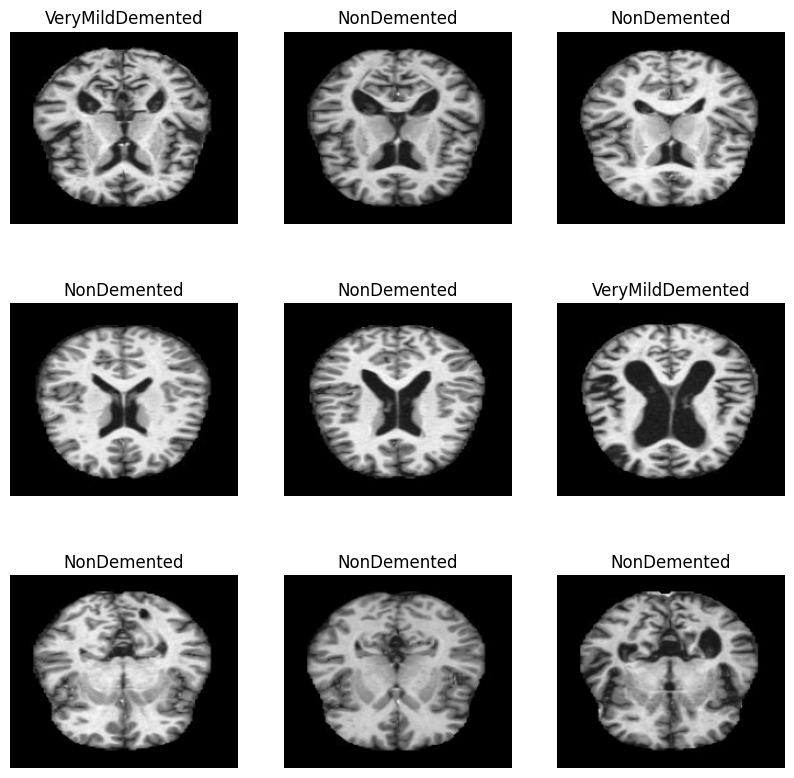

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #Greyscale
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

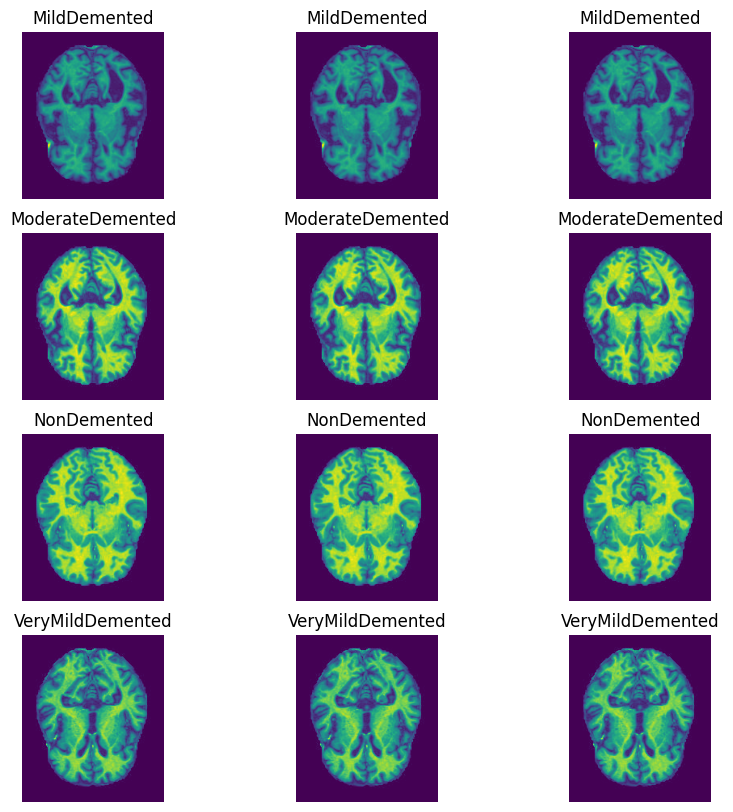

In [6]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
path="../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"
import subprocess
import re

plt.figure(figsize=(10,10))
#subplot(r,c) provide the no. of rows and columns
#f, axarr = plt.subplots(4,3)
i=0
j=0

for cls in class_names:
    result = subprocess.run(['ls', path+cls], stdout=subprocess.PIPE)
    res=result.stdout.decode('utf-8')
    res=re.sub(r'\n', ' ', res)
    file_list=res.split(' ')
    j=0
    for x in range(0, 3):
        # (nrows, ncols, index out of entire array of images)
        ax=plt.subplot(4,3,(3*i)+j+1)
        img=plt.imread(path+cls+'/'+file_list[i])
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        j+=1
    i+=1

**Feature Engineering**

In [7]:
# assigning one hot encoding of labels to train and val dataset
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=autotune)
val_dataset = val_dataset.map(one_hot_label, num_parallel_calls=autotune)

In [8]:
# preprocessing stage => rescaling pixel values of images
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)

**checking numbers of images are in each class for our training data**

In [9]:
num_images_per_class = []

for label in class_names:
    dir_name = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/" + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
num_images_per_class

[717, 52, 2560, 1792]

In [10]:
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight(class_weight="balanced",classes=[0,1,2,3], y=np.asarray(y_train))
class_weights
# these weights will be used in fit procedure to compute class-weighted loss

array([ 1.78556485, 24.62019231,  0.50009766,  0.71442522])

**Transfer Learning **

In [12]:
# Create the base model from the pre-trained VGG16 architecture
base_model = tf.keras.applications.VGG16(input_shape=(*target, 3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

58889256/58889256 [==============================] - 0s 0us/step
(32, 5, 6, 512)


In [13]:
# freezing base_model layers
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [14]:
# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [15]:
# Classification head layer
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [16]:
# TL model with frozen base
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow_addons as tfa

inputs = tf.keras.Input(shape=(*target, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)        #rescaling
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# using AUC and Weighted-F1Score as primary metrics
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                             

**Training the Model**

In [17]:
# Callbacks
import numpy as np
from keras.callbacks import Callback

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("dementia_model.h5",
                                                    save_best_only=True, monitor="val_loss", mode='min')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True, monitor="val_loss", mode='min')
cb=[checkpoint_cb, early_stopping_cb]
# using 2 callbacks; 
# save best selected model with least val_loss, 
# terminate training run if val_loss doesnt change for 10 epochs

In [18]:
# Validation scores before training
model.evaluate(val_dataset)

32/32 [==============================] - 7s 101ms/step - loss: 1.9513 - auc: 0.4168 - f1: 0.1847 - acc: 0.3535


[1.9512563943862915, 0.4168035387992859, 0.18466472625732422, 0.353515625]

In [19]:
# run_1 (training classification head after feature extraction)
history1 = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/50
129/129 [==============================] - 19s 134ms/step - loss: 1.4779 - auc: 0.5103 - f1: 0.2906 - acc: 0.2531 - val_loss: 1.5066 - val_auc: 0.3027 - val_f1: 0.0019 - val_acc: 0.0078
Epoch 2/50
129/129 [==============================] - 9s 68ms/step - loss: 1.3979 - auc: 0.5671 - f1: 0.3536 - acc: 0.3075 - val_loss: 1.5186 - val_auc: 0.4112 - val_f1: 0.0248 - val_acc: 0.0195
Epoch 3/50
129/129 [==============================] - 9s 69ms/step - loss: 1.3748 - auc: 0.5855 - f1: 0.3742 - acc: 0.3180 - val_loss: 1.4466 - val_auc: 0.4552 - val_f1: 0.1496 - val_acc: 0.0957
Epoch 4/50
129/129 [==============================] - 10s 73ms/step - loss: 1.3266 - auc: 0.6471 - f1: 0.4245 - acc: 0.3744 - val_loss: 1.4608 - val_auc: 0.4898 - val_f1: 0.1591 - val_acc: 0.1035
Epoch 5/50
129/129 [==============================] - 10s 74ms/step - loss: 1.3109 - auc: 0.6528 - f1: 0.4296 - acc: 0.3759 - val_loss: 1.4554 - val_auc: 0.4618 - val_f1: 0.2233 - val_acc: 0.1533
Epoch 6/50
129/129 [=

In [20]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [21]:
# Fine-tune from this layer onwards
fine_tune_at = 12

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# 65 layers are set trainable in bottom up manner from classification head
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                             

In [22]:
model.evaluate(val_dataset)

32/32 [==============================] - 2s 54ms/step - loss: 1.0804 - auc: 0.8001 - f1: 0.5737 - acc: 0.5459


[1.0803680419921875, 0.8001195788383484, 0.5736605525016785, 0.5458984375]

In [23]:
# run_2 (fine tuning the pretrained layers)
history2 = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/70
129/129 [==============================] - 16s 97ms/step - loss: 4.9645 - auc: 0.4978 - f1: 0.1256 - acc: 0.0854 - val_loss: 1.3919 - val_auc: 0.4346 - val_f1: 9.2826e-05 - val_acc: 0.0068
Epoch 2/70
129/129 [==============================] - 13s 97ms/step - loss: 1.4147 - auc: 0.4351 - f1: 2.3866e-04 - acc: 0.0110 - val_loss: 1.3930 - val_auc: 0.4346 - val_f1: 9.2826e-05 - val_acc: 0.0068
Epoch 3/70
129/129 [==============================] - 13s 96ms/step - loss: 1.4147 - auc: 0.3468 - f1: 2.3866e-04 - acc: 0.0110 - val_loss: 1.3969 - val_auc: 0.3379 - val_f1: 9.2826e-05 - val_acc: 0.0068
Epoch 4/70
129/129 [==============================] - 12s 90ms/step - loss: 1.4146 - auc: 0.3347 - f1: 2.3866e-04 - acc: 0.0110 - val_loss: 1.3994 - val_auc: 0.3267 - val_f1: 9.2826e-05 - val_acc: 0.0068
Epoch 5/70
129/129 [==============================] - 12s 90ms/step - loss: 1.4145 - auc: 0.3310 - f1: 2.3866e-04 - acc: 0.0110 - val_loss: 1.3995 - val_auc: 0.3267 - val_f1: 9.2826e-05 - 

**Evalute test model**

In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
    image_size=target,
    batch_size=batch,
    shuffle=False,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

Found 1279 files belonging to 4 classes.


In [25]:
model.evaluate(test_ds)

40/40 [==============================] - 6s 160ms/step - loss: 1.3918 - auc: 0.4347 - f1: 1.7442e-04 - acc: 0.0094


[1.3918356895446777,
 0.4347146153450012,
 0.00017441976524423808,
 0.009382329881191254]

In [26]:
predictions=model.predict(test_ds)

40/40 [==============================] - 2s 46ms/step


In [27]:
# list of number of images belonging to each class in test directory
test_images = []

for label in class_names:
    dir_name = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/" + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

[179, 12, 640, 448]

In [28]:
# targets list
targets=[]
for i in range(0, len(test_images)):
    targets+=[i]*test_images[i]
targets=np.asarray(targets)
test_images, class_names, targets

([179, 12, 640, 448],
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
 array([0, 0, 0, ..., 3, 3, 3]))

In [29]:
from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.01      1.00      0.02        12
     NonDemented       0.00      0.00      0.00       640
VeryMildDemented       0.00      0.00      0.00       448

        accuracy                           0.01      1279
       macro avg       0.00      0.25      0.00      1279
    weighted avg       0.00      0.01      0.00      1279

